In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import binom_test

In [3]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# direct to AB test folder
%cd /content/drive/My Drive/AB test

Mounted at /content/drive
/content/drive/My Drive/AB test


# **Udacity A/B test on a screener feature**






## **Background**


Udacity's mission is centered around bridging the gap between learning and career advancement by offering accessible, high-quality and industry-relevent education. This task on Udacity website is to test a idea to improve user experience when student clicked on "start free trial"

1.   Statu quo


*   Students have two options on the course: start free trial or access course materials
*   Start free trial: students will enter their credit card information and they will have access to the paid course. After 14 days, the card will charged automatically unless they cancel first
*   Access course materials: students will have access to view videos and quizzes for free but they will not receive support or verified certificate.

2.   Treatment

*   If a student clicked on "start free trial", they were asked how much time they has available to devote to the course.
*   If the student indicated 5 or more hours per week, they would be taken through a checkout process where they entered their credit card information.
*   For the student who indicated fewer than 5 hours per week, a message would show to suggest the student might like to access the materials for free

3.   Goal
*   This is trying to improve the overall student experience and improve the support capacity for students are likely to complete courses by reducing the number of frustrated students who did not have enough time to complete the course

## **Funnel and metrics**
The challenge provides following metrics to choose for invariant or evaluation metrics:

*  Number of cookies: number of unique cookies to view the course overview page. (dmin=3000)
*  Number of user-ids: number of users who enroll in the free trial. (dmin=50)
*  Number of clicks: number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). (dmin=240)
*  Click-through-probability: number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. (dmin=0.01)
*  Gross conversion: number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. (dmin= 0.01)
*  Retention: number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. (dmin=0.01)
*  Net conversion: number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)

Here shows the funnel and metrics' relationship to the funnel.
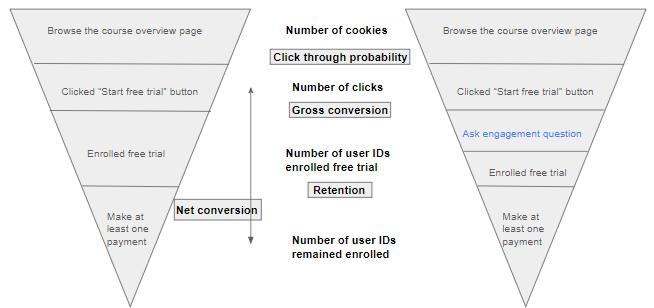




1.   Invariant metrics. Due the randomly assignment of cookied to each groups, the metrics that remain unchanged for the control and experiment groups are

      *   Number of cookies
      *   Number of clicks
      *   Click through probability

2.   Evaluation metrics
      *   Gross conversion(**GC**), we expect the gross conversion rate decrease because we divert users that do not seem to be a good fit for paid version to free version.
      *   Retention(**R**), we expect the retention increase because the divertion filter out users who are likely to churn
      *   Net conversion(**NC**), we expect the rate to increase as the same reason of retention and thus it improves the user's experience

## **Hypothesis**
Here are the corresponding hypothesis for the three evaluation metrics. To be more conservative, two sided test is used.

1.   H0: Gross conversion of both groups are equal

     H1: Gross conversion of both groups are not equal
2.   H0: Retention of both groups are equal

     H1: Retention of both groups are not equal
3.   H0: Net conversion of both groups are equal

     H1: Net conversion of both groups are not equal



## **Standard Deviation Calculation**
Estimator of metrics is provided by Udacity and given a sample size of 5000 cookies visiting the course overview page, standard deviation is calculated

In [4]:
estimators = pd.read_csv('Final Project Baseline Values.csv', names=["metrics","values"], header=None)
estimators.index =["C", "CL", "ID", "CTP", "CG", "R", "CN"]
estimators["dmin"] = [3000, 240, -50, 0.01, -0.01, 0.01, 0.0075]
estimators.insert (2, "scaled_Est", np.nan)

# scale the counts
#scale count estimates
scaling_factor = 5000/estimators.loc["C"]["values"]

for i in ["C", "CL", "ID"]:
    estimators.at[i, "scaled_Est"] = estimators.loc[i]["values"] * scaling_factor

estimators

,metrics,values,scaled_Est,dmin
C,Unique cookies to view course overview page pe...,40000.000000,5000.0,3000.0000
CL,"Unique cookies to click ""Start free trial"" per...",3200.000000,400.0,240.0000
ID,Enrollments per day:,660.000000,82.5,-50.0000
CTP,"Click-through-probability on ""Start free trial"":",0.080000,NaN,0.0100
CG,"Probability of enrolling, given click:",0.206250,NaN,-0.0100
R,"Probability of payment, given enroll:",0.530000,NaN,0.0100
CN,"Probability of payment, given click",0.109313,NaN,0.0075


Before estimating standard deviation, we should be checking the normal distribution assumption by the 3 standard deviation rule.
$$
\begin{equation}
n > 9(\frac{1-p}{p})
\end{equation}
$$
and
$$
\begin{equation}
n > 9(\frac{p}{1-p})
\end{equation}
$$

In [5]:
def checkN (n, p, metric):
    '''Given sample size n and probability p, return whether n is large enough to pass the 3-standard deviation rule,
    i.e. whether we can assume that the distribution can be approximated by the normal distribution'''
    if n > 9*((1-p)/p) and n > 9*(p/(1-p)):
        result = print(metric,":  n =", n, "is large enough to assume normal distribution approximation")
    else:
        result = print(metric,":  n =", n, "is not large enough to assume normal distribution approximation")
    return result

#check whether n is large enough to assume normal distribution approximation
for i,j in zip(["CL", "ID", "CL"],["CG", "R", "CN"]):
    checkN (estimators.at[i, "scaled_Est"], estimators.at[j,"values"], estimators.at[j,"metrics"])

Probability of enrolling, given click: :  n = 400.0 is large enough to assume normal distribution approximation
Probability of payment, given enroll: :  n = 82.5 is large enough to assume normal distribution approximation
Probability of payment, given click :  n = 400.0 is large enough to assume normal distribution approximation


Standard deviation formula for randomly assigned samples of size n from a normal distribution

$$
SE = \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$


In [6]:
#create new column to store standard errors
estimators["SE"] = np.nan

#formula to calculate standard deviation
def standardError (n, p):
    '''Return the standard deviation for a given probability p and sample size n'''
    return (p*(1-p)/n)**0.5

#calculating standard errors for evaluation metrics and store them in md
for i in ["CG", "CN"]:
    estimators.at[i, "SE"] = standardError(estimators.loc["CL"]["scaled_Est"], estimators.loc[i]["values"])

estimators.at["R", "SE"] = standardError(estimators.loc["ID"]["scaled_Est"], estimators.loc["R"]["values"])
estimators

,metrics,values,scaled_Est,dmin,SE
C,Unique cookies to view course overview page pe...,40000.000000,5000.0,3000.0000,NaN
CL,"Unique cookies to click ""Start free trial"" per...",3200.000000,400.0,240.0000,NaN
ID,Enrollments per day:,660.000000,82.5,-50.0000,NaN
CTP,"Click-through-probability on ""Start free trial"":",0.080000,NaN,0.0100,NaN
CG,"Probability of enrolling, given click:",0.206250,NaN,-0.0100,0.020231
R,"Probability of payment, given enroll:",0.530000,NaN,0.0100,0.054949
CN,"Probability of payment, given click",0.109313,NaN,0.0075,0.015602


## **Experiment setup**
We are using alpha 0.05 and beta of 0.2, indicating statisical power of 0.8

In [7]:
#storing alpha and beta in a dictionary
error_prob = {"alpha": 0.05, "beta": 0.20}
error_prob

{'alpha': 0.05, 'beta': 0.2}

### **Math for size**
Figure 2.1 summarizes graphically the ingredients in sample size calculations.
The null hypothesis provides the basis for determining the rejection region, whether
the test is one-sided or two-sided, and the probability of a Type I error (α)–the size
of the test. The alternative hypothesis then defines the power and the Type II error
(β)

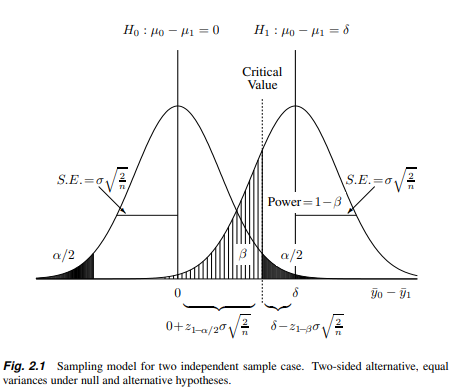

The critical value defines the boundary between the rejection and nonrejection regions. Thus the value should be the same for both null and alternative hypothesis.

If the variance and sample size are equal, then

$$
0 + z_{1-\alpha/2}σ\sqrt{\frac{2}{n}} = d_{min} -  z_{1-\beta}σ\sqrt{\frac{2}{n}}
$$

If the variance and sample size are not equal, then
$$
0 + z_{1-\alpha/2}σ_0\sqrt{\frac{1}{n_0}+\frac{1}{n_1}} = d_{min} -  z_{1-\beta}\sqrt{\frac{σ_0^2}{n_0}+\frac{σ_1^2}{n_1}}
$$

Because the variances are not necessarily equal, the second formula is applied. Then the sample size n is:

$$
n = \frac{(z_{1-\alpha/2}\sqrt{2σ_0^2} + z_{1-\beta}\sqrt{σ_0^2+σ_1^2})^2}{d_{min}^2}
$$
Where
$$
σ_0^2 = \hat{p}(1-\hat{p})
$$
$$
σ_1^2 = (\hat{p}+d_{min})(1-\hat{p}-d_{min})
$$

We have to keep in mind that we would like to have the sample size in the unit of diversion, which is cookie that visit page. Thus, the samples size for each group should be scaled to pageviews over the course overview by cookie. For example, number of clicks by cookied should be devided by click through probability to scale back to pageview by cookie.

In [8]:
#create new column n_c to store sample sizes
estimators["n_C"] = np.nan

#define function for approach B
def get_sampleSize (alpha, beta, p, dmin):
    '''Return sample size given alpha, beta, p and dmin'''
    return (pow((stats.norm.ppf(1-alpha/2)*(2*p*(1-p))**0.5+stats.norm.ppf(1-beta)*(p*(1-p)+(p+dmin)*(1-(p+dmin)))**0.5),2))/(pow(dmin,2))

#calculate sample sizes for evaluation metrics with defined adjustments and store results in md
for i in ["CG", "CN"]:
    estimators.at[i, "n_C"] = round((get_sampleSize(error_prob["alpha"], error_prob["beta"], estimators.loc[i]["values"], estimators.loc[i]["dmin"])/estimators.loc["CTP"]["values"]))

estimators.at["R", "n_C"] = round(((get_sampleSize(error_prob["alpha"], error_prob["beta"], estimators.loc["R"]["values"], estimators.loc["R"]["dmin"])/estimators.loc["CTP"]["values"])/estimators.loc["CG"]["values"]))
estimators

,metrics,values,scaled_Est,dmin,SE,n_C
C,Unique cookies to view course overview page pe...,40000.000000,5000.0,3000.0000,NaN,NaN
CL,"Unique cookies to click ""Start free trial"" per...",3200.000000,400.0,240.0000,NaN,NaN
ID,Enrollments per day:,660.000000,82.5,-50.0000,NaN,NaN
CTP,"Click-through-probability on ""Start free trial"":",0.080000,NaN,0.0100,NaN,NaN
CG,"Probability of enrolling, given click:",0.206250,NaN,-0.0100,0.020231,319470.0
R,"Probability of payment, given enroll:",0.530000,NaN,0.0100,0.054949,2368885.0
CN,"Probability of payment, given click",0.109313,NaN,0.0075,0.015602,342667.0


### **Duration and Size**

The overall daily traffic on Udacity amounts to approximately 40,000 pageviews. For the experiment, we plan to redirect 50% of this traffic. Consequently, the following outlines the duration required for each hypothesis:

CG: 32 days
R: 236 days
CN: 34 days
While the week-long duration provides a favorable mix of user behaviors on weekdays and weekends, a crucial concern arises for the retention hypothesis. The experiment extends over 8 months, posing significant risks for three main reasons:

Opportunity cost: The experiment's 50% traffic allocation prevents testing other treatments, resulting in a prolonged loss of opportunities.
Delayed detection of harm: If the treatment proves harmful, identification only occurs after an extensive 8-month period, introducing inherent risks.
Changing user behavior: Over such an extended period, user behavior may undergo significant shifts, rendering distant data points less comparable.
Considering these factors, we have decided to exclude retention as an evaluation metric and focus solely on CG and CN. Furthermore, using CG and CN can still provide valuable insights into retention.








### **Multiple hypothesis**

With multiple hypotheses in play, the risk of encountering false positives is elevated. Despite the metrics not being entirely independent, the actual probability of false positives remains below 9.75%, the rate for independent metrics. While family-wise error rate correction methods like Bonferroni or false discovery rate methods exist to address the multiple hypotheses issue, they come with their own set of drawbacks, such as an increased likelihood of false negatives.

In this particular scenario, where the increment in false positives is only marginal, we have chosen not to implement controls for multiple hypotheses.

## **Evaluation**

In [9]:
#loading experiment data into new dataframes
control = pd.read_csv("Final Project Results - Control.csv")
experiment = pd.read_csv("Final Project Results - Experiment.csv")

#check if loaded correctly
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [10]:
#check if loaded correctly
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


In [11]:
#check number of entries
control.count()

Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64

In [12]:
#check number of entries
experiment.count()

Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64

In [13]:
#check sample size and store it as sample_size
sample_size_control = control["Pageviews"].sum()
sample_size_experiment = experiment["Pageviews"].sum()
sample_size = sample_size_control+sample_size_experiment
sample_size

690203

### **Sanity Checks**

To verify the proper execution of the experiment, we initiate a sanity check by examining the three specified invariant metrics. These metrics encompass:

*   Number of cookies
*   Number of clicks
*   Click through probability

As previously mentioned, the expectation is that these metrics exhibit no significant differences between the control and treatment groups. Any substantial disparities would suggest potential issues with the experiment setup, raising concerns about the reliability and impartiality of our results.










**Number of cookies and clicks**

To assess the statistical distinction between the number of cookies and clicks assigned to each group, a hypothesis test can be conducted on the rate allocated to the control group. Formally, the null hypothesis posits that the rate is 0.5, while the alternative hypothesis asserts that the rate is not equal to 0.5. This test allows us to evaluate whether there is evidence to reject the assumption that the assignment rate is evenly distributed between the groups.

In [14]:
#create empty dataframe to store sanity check results
sanity_check = pd.DataFrame(columns=["CI_left", "CI_right", "obs","passed?"], index=["C", "CL", "CTP"])

#set alpha and p_hat
p = 0.5
alpha = 0.05

#fill dataframe with results from binomial test
#for cookies and clicks do the following
for i,j in zip(["C", "CL"], ["Pageviews", "Clicks"]):
    #calculate the number of successes (n_control) and number of observations (n)
    n = control[j].sum()+experiment[j].sum()
    n_control = control[j].sum()

    #compute confidence interval
    sanity_check.at[i, "CI_left"] = p-(stats.norm.ppf(1-alpha/2)*standardError(n,p))
    sanity_check.at[i, "CI_right"] = p+(stats.norm.ppf(1-alpha/2)*standardError(n,p))

    #compute observed fraction of successes
    sanity_check.at[i, "obs"] = round(n_control/(n),4)

    #check if the observed fraction of successes lies within the 95% confidence interval
    if sanity_check.at[i, "CI_left"] <= sanity_check.at[i, "obs"] <= sanity_check.at[i, "CI_right"]:
        sanity_check.at[i, "passed?"] = "yes"
    else:
        sanity_check.at[i, "passed?"] = "no"

#return results
sanity_check

,CI_left,CI_right,obs,passed?
C,0.49882,0.50118,0.5006,yes
CL,0.495885,0.504115,0.5005,yes
CTP,NaN,NaN,NaN,NaN


**Click through probability**

To check if the click through probability are significantly different in the two group, two proportion z-test can be conducted. The assumption is the two populations have normal distributions but not necessarily the same variance. The first step is to calculate the pool standard error. The second step is to calculate confidence interval with a mean of 0 and the third step is to check if the observed value is within the CI. Alternatively, we can calculate the Z-test statistic and check the corresponding p-value against the alpha of 0.05.

$$
SE = \sqrt{\frac{S_{cont}^2}{n_{cont, pageviews}}+\frac{S_{exp}^2}{n_{exp, pageviews}}}
$$

where
$$
S = \sqrt{p(1-p)}
$$

$$
p=CTP = \frac{n_{clicks}}{n_{pageviews}}
$$
And confidence interval is
$$
CI = [0-Z_{1-α/2}SE, 0+Z_{1-α/2}SE]
$$

In [15]:
#compute CTP for both groups
CTP_control = control["Clicks"].sum()/control["Pageviews"].sum()
CTP_experiment = experiment["Clicks"].sum()/experiment["Pageviews"].sum()

#compute sample standard deviations for both groups
S_control = (CTP_control*(1-CTP_control))**0.5
S_experiment = (CTP_experiment*(1-CTP_experiment))**0.5

#compute SE_pooled
SE_pooled = (S_control**2/control["Pageviews"].sum()+S_experiment**2/experiment["Pageviews"].sum())**0.5

#compute 95% confidence interval and store it in sanity check
alpha = 0.05

sanity_check.at["CTP", "CI_left"] = 0-(stats.norm.ppf(1-alpha/2)*SE_pooled)
sanity_check.at["CTP", "CI_right"] = 0+(stats.norm.ppf(1-alpha/2)*SE_pooled)

#compute observed difference d and store it in sanity check
sanity_check.at["CTP", "obs"] = round(CTP_experiment - CTP_control,4)

#check if sanity check is passed
if sanity_check.at["CTP", "CI_left"] <= sanity_check.at["CTP", "obs"] <= sanity_check.at["CTP", "CI_right"]:
    sanity_check.at["CTP", "passed?"] = "yes"
else:
    sanity_check.at["CTP", "passed?"] = "no"

#return results
sanity_check

,CI_left,CI_right,obs,passed?
C,0.49882,0.50118,0.5006,yes
CL,0.495885,0.504115,0.5005,yes
CTP,-0.001296,0.001296,0.0001,yes


### **Evaluation Metrics Checks**
Recall the two evaluation metrics:

*   CG: gross conversion
$$
CG = \frac{n_{usersEnrolled}}{n_{clicks}}
$$
*   CN: Net conversion
$$
CN = \frac{n_{usersPaid}}{n_{clicks}}
$$

Similar to the hypothesis test on the click through rate, hypothesis test can be performed on the two metrics like below:

CG:

*   $$H_0: CG_{exp} = CG_{Cont}$$
*   $$H_1: CG_{exp} <> CG_{Cont}$$

CH:

*   $$H_0: CN_{exp} = CN_{Cont}$$
*   $$H_1: CN_{exp} <> CN_{Cont}$$


Due to the limited availability of payment and enrollment information in the dataset, our analysis is confined to utilizing data from the initial 23 days only.

In [27]:
#compute true sample size
true_sample_size = control.iloc[:23]["Pageviews"].sum()+experiment.iloc[:23]["Pageviews"].sum()
true_sample_size

423525

In [28]:
#create dataframe test_results
test_results = pd.DataFrame(columns=["CI_left", "CI_right", "d","stat sig?", "dmin", "pract rel?"], index=["CG", "CN"])

#set alpha
alpha = 0.05


#run two proportion z test for both metrics
for i,j in zip(["Enrollments", "Payments"],["CG", "CN"]):
    #compute sample conversion rates
    conv_control = control.iloc[:23][i].sum()/control.iloc[:23]["Clicks"].sum()
    conv_experiment = experiment.iloc[:23][i].sum()/experiment.iloc[:23]["Clicks"].sum()

    #compute observed difference between treatment and control conversion d
    test_results.at[j, "d"] = conv_experiment-conv_control

    #compute sample standard deviations
    S_control = (conv_control*(1-conv_control))**0.5
    S_experiment = (conv_experiment*(1-conv_experiment))**0.5

    #compute SE_pooled
    SE_pooled = (S_control**2/control.iloc[:23]["Clicks"].sum()+S_experiment**2/experiment.iloc[:23]["Clicks"].sum())**0.5

    #compute 95% confidence interval around observed difference d
    test_results.at[j, "CI_left"] = test_results.at[j, "d"]-(stats.norm.ppf(1-alpha/2)*SE_pooled)
    test_results.at[j, "CI_right"] = test_results.at[j, "d"]+(stats.norm.ppf(1-alpha/2)*SE_pooled)

    #check statistical significance
    if test_results.at[j, "CI_left"] <= 0 <= test_results.at[j, "CI_right"]:
        test_results.at[j, "stat sig?"] = "no"
    else:
        test_results.at[j, "stat sig?"] = "yes"

    #import dmin
    test_results.at[j, "dmin"] = estimators.loc[j]["dmin"]


    #check if practical relevant
    #check if dmin is positive or negative
    if test_results.at[j, "dmin"] >= 0:
        #check if d is larger than dmin and if dmin lies left of the confidence interval around d
        if test_results.at[j, "d"] > test_results.at[j, "dmin"] and test_results.at[j, "CI_left"] > test_results.at[j, "dmin"]:
                test_results.at[j, "pract rel?"] = "yes"
        else:
            test_results.at[j, "pract rel?"] = "no"
    else:
        #check if d is smaller than dmin and if dmin lies right of the confidence interval around d
        if test_results.at[j, "d"] < test_results.at[j, "dmin"] and test_results.at[j, "dmin"] > test_results.at[j, "CI_right"]:
                test_results.at[j, "pract rel?"] = "yes"
        else:
            test_results.at[j, "pract rel?"] = "no"

#return results
test_results

,CI_left,CI_right,d,stat sig?,dmin,pract rel?
CG,-0.02912,-0.01199,-0.020555,yes,-0.01,yes
CN,-0.011604,0.001857,-0.004874,no,0.0075,no


### **Sign test**

In [36]:
signTest = control.iloc[:23].merge(experiment.iloc[:23], on="Date", how="inner", suffixes=["_cont", "_exp"])
signTest["CG_cont"] =  signTest["Enrollments_cont"]/signTest["Clicks_cont"]
signTest["CG_exp"] =  signTest["Enrollments_exp"]/signTest["Clicks_exp"]
signTest["CN_cont"] =  signTest["Payments_cont"]/signTest["Clicks_cont"]
signTest["CN_exp"] =  signTest["Payments_exp"]/signTest["Clicks_exp"]
signTest["CG_sign"] = signTest["CG_exp"] >  signTest["CG_cont"]
signTest["CN_sign"] = signTest["CN_exp"] >  signTest["CN_cont"]

In [38]:
signTest[["CG_sign", "CN_sign"]].sum()

CG_sign     4
CN_sign    10
dtype: int64

In [57]:
binom_test(4,23,0.5)

0.002599477767944336

In [54]:
binom_test(10,23,0.5)

0.6776394844055176

### **Interpretation and discussion**
The gross conversion analysis reveals that the observed gross conversion in the treatment group is approximately 2.06% less than that observed in the control group. Additionally, the values within the confidence interval predominantly suggest compatibility with a negative effect, which is also supported by the sign test, where p value of two sided test is 0.0026. Importantly, this observed effect seems to hold practical significance, as these values fall below dmin, the minimum effect size deemed relevant for the business.

For the net conversion analysis, although we are unable to reject the null hypothesis based on the test results, it is notable that the observed net conversion in the treatment group is approximately 0.49% less than the net conversion observed in the control group. Moreover, the values considered most reasonably compatible with the data fall within a range from -1.16% to 0.19% but it does not exclude 0.

Based on the observed results, it seems reasonable to assume that the introduction of the "Free Trial Screener" might aid in establishing clearer expectations for students upfront. However, the findings are less supportive of the notion that the decline in gross conversion is entirely compensated by an enhancement in the overall student experience. Furthermore, the results are still less aligned with dmin(net conversion), the minimum effect size deemed relevant for the business.

Considering Udacity's likely interest in revenue growth, the recommendation would be to refrain from rolling out the "Free Trial Screener" feature based on the current analysis. The potential negative impact on gross conversion, combined with the limited improvement in net conversion, suggests that the feature may not yield the desired business outcomes. Further evaluation or iteration may be needed before considering a broader implementation.